<a href="https://colab.research.google.com/github/gegretel/AML-4/blob/master/project4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project 4**
**Author name:** getong liu

**Purpose:**

performing experiments involving regression using the Beijing PM2.5 Data Set

1.Perform data scrubbing (handle missing data, normalization, scaling, etc.)

2.Perform linear as well as non-linear regression on the dataset 

3.Evaluate the performance of  each model using k-fold cross validation

4.Plot and compare learning curves for all models 

5.Fully discuss which model performs the best and why



# **Set up**

First, let's make sure this notebook works well in both python 2 and 3,import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [0]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "fundamentals"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

**1.Perform data scrubbing (handle missing data, normalization, scaling, etc.)** 

# **Get the data**

**(1).Loading data**



Firstly, we should load our data here. last few times, these data set can simply load by keras or download from sklearn, however since we will dealing with lot of another data set in the future,which is not simply load anymore, it is better to find out a good way to load data, except using github, I found google colab can load data from google drive, but we need install opam then also install google-drive-ocamlfuse too first here.

secondly, after we install them, we just can simply using 'ls' to list all the file at the drive, and find the file which we need so that we can load it from google drive.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#install opam,then google-drive-ocamlfuse
!apt-get install opam
!opam init
!opam update
!opam install depext
!opam depext google-drive-ocamlfuse
!opam install google-drive-ocamlfuse
#give permission
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!/root/.opam/system/bin/google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | /root/.opam/system/bin/google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
# choose Google Drive as root directory，named as drive
!mkdir -p drive
!/root/.opam/system/bin/google-drive-ocamlfuse drive

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  aspcud camlp4 clasp darcs file gringo ledit libcamlp4-ocaml-dev
  libfindlib-ocaml libfindlib-ocaml-dev liblua5.3-0 libmagic-mgc libmagic1
  mercurial mercurial-common ocaml ocaml-base ocaml-base-nox
  ocaml-compiler-libs ocaml-findlib ocaml-interp ocaml-nox opam-docs
Suggested packages:
  kdiff3 | kdiff3-qt | kompare | meld | tkcvs | mgdiff qct python-mysqldb
  python-openssl python-pygments ocaml-doc tuareg-mode | ocaml-mode
The following NEW packages will be installed:
  aspcud camlp4 clasp darcs file gringo ledit libcamlp4-ocaml-dev
  libfindlib-ocaml libfindlib-ocaml-dev liblua5.3-0 libmagic-mgc libmagic1
  mercurial mercurial-common ocaml ocaml-base ocaml-base-nox
  ocaml-compiler-libs ocaml-findlib

In [0]:
#注意ls的路径在 /content
%ls /content

adc.json  drive/  sample_data/


In [0]:
#比如我的目录是app
#直接 
%cd /content/drive/My Drive/Colab Notebooks

/content/drive/My Drive/Colab Notebooks


In [0]:
%ls

'AMLASSIGN3 (1).ipynb'   PRSA_data_2010.1.1-2014.12.31.csv   Untitled0.ipynb
'AMLASSIGN3 (2).ipynb'  'svm (1).ipynb'                      Untitled1.ipynb
 AMLASSIGN3.ipynb       'svm (2).ipynb'                      Untitled.ipynb
'Copy of Untitled'       svm.ipynb
 project2.ipynb         'SVM PCA RandomForest.ipynb'


In [53]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**(2).Imput all the necessary package**

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import warnings
# filter warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures


import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error,r2_score
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV




In [0]:
os.chdir("/content/gdrive/My Drive/")

**(3).show the data information by column, and show the data's type imformation, also plot each data's picture.**

In [335]:
df=pd.read_csv("./Colab Notebooks/PRSA_data_2010.1.1-2014.12.31.csv")
df.head()


,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [336]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 13 columns):
No       43824 non-null int64
year     43824 non-null int64
month    43824 non-null int64
day      43824 non-null int64
hour     43824 non-null int64
pm2.5    41757 non-null float64
DEWP     43824 non-null int64
TEMP     43824 non-null float64
PRES     43824 non-null float64
cbwd     43824 non-null object
Iws      43824 non-null float64
Is       43824 non-null int64
Ir       43824 non-null int64
dtypes: float64(4), int64(8), object(1)
memory usage: 4.3+ MB


In [306]:
df.describe()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
count,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,41757.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000
mean,21912.500000,2012.000000,6.523549,15.727820,11.500000,98.613215,1.817246,12.448521,1016.447654,23.889140,0.052734,0.194916
std,12651.043435,1.413842,3.448572,8.799425,6.922266,92.050387,14.433440,12.198613,10.268698,50.010635,0.760375,1.415867
min,1.000000,2010.000000,1.000000,1.000000,0.000000,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,10956.750000,2011.000000,4.000000,8.000000,5.750000,29.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,21912.500000,2012.000000,7.000000,16.000000,11.500000,72.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,32868.250000,2013.000000,10.000000,23.000000,17.250000,137.000000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,43824.000000,2014.000000,12.000000,31.000000,23.000000,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


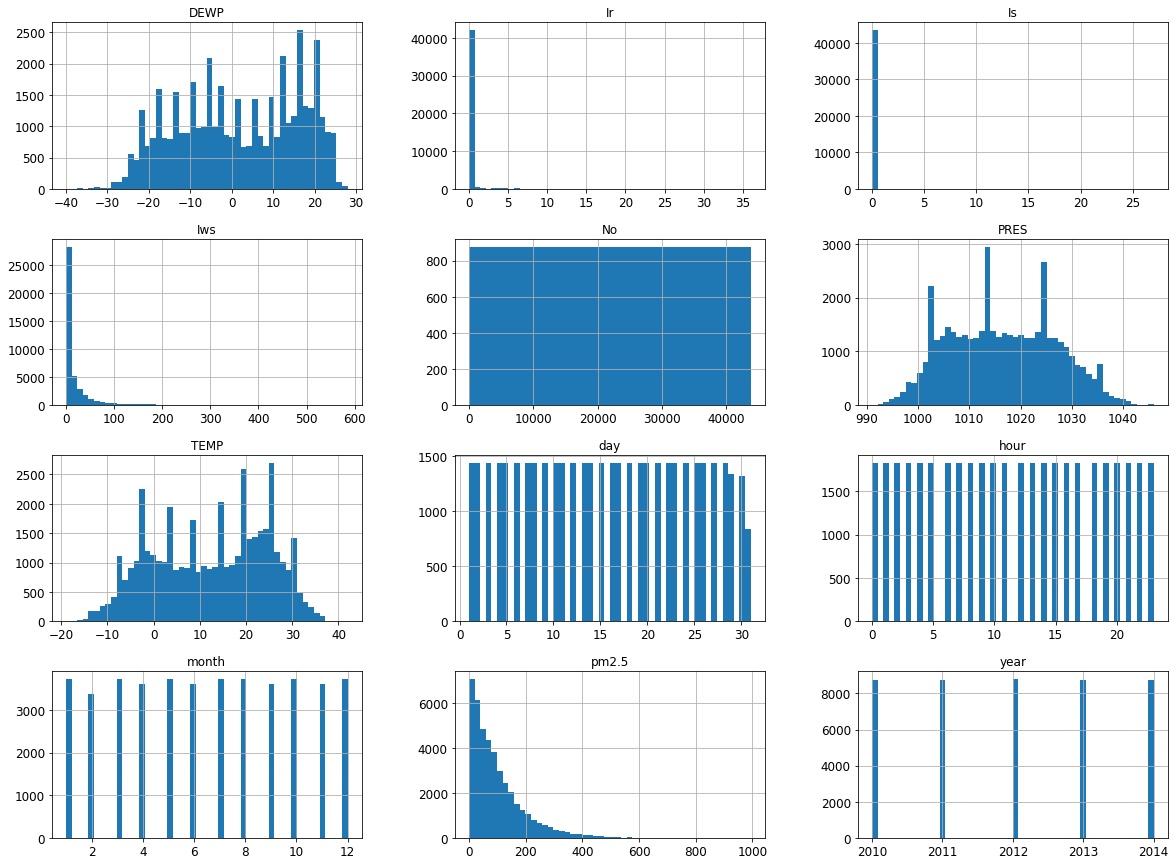

In [307]:
%matplotlib inline

df.hist(bins=50, figsize=(20,15))
plt.show()

# **Prepare the data for Machine Learning algorithms**

**now, for machine learning algorithms, we need clean all the data.**

Firstly, sometimes due to data mising, there are some NA value at the data set, which will impact our result, so we need check where and how much missing data we have. 

Secondly,after we using 'df.isna().sum()', it shows that only 2067 missing data of pm 2.5, comparing with the whole dataset which have 43824 data, it is very small, so I choosed drop all the NA data.(but I also used anther way which is add median value inside NA place, however, the results shows dropping NA data will get higher predict value).

thirdly, because if we need do algorithms, we need to change all the column's value to be number, however cbwd is not number here, so I replaced these value by number.

In [337]:
df.isna().sum()

No          0
year        0
month       0
day         0
hour        0
pm2.5    2067
DEWP        0
TEMP        0
PRES        0
cbwd        0
Iws         0
Is          0
Ir          0
dtype: int64

In [0]:
df.dropna(inplace=True)

In [339]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41757 entries, 24 to 43823
Data columns (total 13 columns):
No       41757 non-null int64
year     41757 non-null int64
month    41757 non-null int64
day      41757 non-null int64
hour     41757 non-null int64
pm2.5    41757 non-null float64
DEWP     41757 non-null int64
TEMP     41757 non-null float64
PRES     41757 non-null float64
cbwd     41757 non-null object
Iws      41757 non-null float64
Is       41757 non-null int64
Ir       41757 non-null int64
dtypes: float64(4), int64(8), object(1)
memory usage: 4.5+ MB


In [340]:
df_word = df[['cbwd']]
df_word.head(10)

,cbwd
24,SE
25,SE
26,SE
27,SE
28,SE
29,SE
30,SE
31,SE
32,SE
33,SE


In [0]:
try:
    from sklearn.preprocessing import OrdinalEncoder
except ImportError:
    from future_encoders import OrdinalEncoder # Scikit-Learn < 0.20

**check whether encdoe or not**

In [342]:
ordinal_encoder = OrdinalEncoder()
df_encoded = ordinal_encoder.fit_transform(df_word)
df_encoded[:50]

array([[2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [3.],
       [3.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [343]:
ordinal_encoder.categories_

[array(['NE', 'NW', 'SE', 'cv'], dtype=object)]

In [344]:
df.columns

Index(['No', 'year', 'month', 'day', 'hour', 'pm2.5', 'DEWP', 'TEMP', 'PRES',
       'cbwd', 'Iws', 'Is', 'Ir'],
      dtype='object')

**replace the oraginal data by encode data**

In [0]:
df = df.assign(cbwd= df_encoded)


In [346]:
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
24,25,2010,1,2,0,129.0,-16,-4.0,1020.0,2.0,1.79,0,0
25,26,2010,1,2,1,148.0,-15,-4.0,1020.0,2.0,2.68,0,0
26,27,2010,1,2,2,159.0,-11,-5.0,1021.0,2.0,3.57,0,0
27,28,2010,1,2,3,181.0,-7,-5.0,1022.0,2.0,5.36,1,0
28,29,2010,1,2,4,138.0,-7,-5.0,1022.0,2.0,6.25,2,0


In [0]:
#median = df["pm2.5"].median()
#df["pm2.5"].fillna(median, inplace=True) 


In [0]:
#df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,72.0,-21,-11.0,1021.0,1.0,1.79,0,0
1,2,2010,1,1,1,72.0,-21,-12.0,1020.0,1.0,4.92,0,0
2,3,2010,1,1,2,72.0,-21,-11.0,1019.0,1.0,6.71,0,0
3,4,2010,1,1,3,72.0,-21,-14.0,1019.0,1.0,9.84,0,0
4,5,2010,1,1,4,72.0,-20,-12.0,1018.0,1.0,12.97,0,0


**Now we are ready to using linear as well as non-linear regression on the dataset, at the same time we can do normalization and scaling.**

**2.Perform linear as well as non-linear regression on the dataset**

# **linear regression**

More generally, a linear model makes a prediction by simply computing a weighted sum of the input features, plus a constant call the bias term. the most common performance measure of a regression model is the RMSE.

In this part, uesed linear regression(by using linear model, Gradient Descent, also ridge regression) to measure these data.

Firstly, use corr_matrix to find the reltation between pm2.5 with other column.
and drop off the irrelevant data.

Sencondly, use the linear model to get the MSE and RSME, during this time we find if we scaling the data, it will improve the result.

In [0]:
corr_matrix = df.corr()

In [348]:
corr_matrix["pm2.5"].sort_values(ascending=False)

pm2.5    1.000000
cbwd     0.197150
DEWP     0.171423
day      0.082788
Is       0.019266
year    -0.014690
No      -0.017706
hour    -0.023116
month   -0.024069
PRES    -0.047282
Ir      -0.051369
TEMP    -0.090534
Iws     -0.247784
Name: pm2.5, dtype: float64

In [349]:

y = df['pm2.5']
X = df.drop(columns=['pm2.5','day','year','No','hour','month'])
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3,random_state=42)

print(X_train.shape, y_train.shape)


(29229, 7) (29229,)


In [350]:
linear_model.LinearRegression().get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}

In [351]:
linear=linear_model.LinearRegression()
linear.fit(X_train,y_train)
linear.score(X_train,y_train)
linear.score(X_test,y_test)


0.24996723763427142

In [352]:
linear.coef_
linear.intercept_

1622.894970177442

In [353]:
# data scaling, improve the speed to dealing with the data

ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
 
ss.fit(X_test)

X_test = ss.transform(X_test)

linear.fit(X_train,y_train)
linear.score(X_train,y_train)
linear.score(X_test,y_test)

0.25002517933931534

In [0]:
y_hat=linear.predict(X_train)
y_pre=linear.predict(X_test)
fmse=(y_pre-y_test).T.dot(y_pre-y_test)/len(y_test)
mse=(y_hat-y_train).T.dot(y_hat-y_train)/len(y_train)


In [355]:
fmse

6410.867356985548

In [356]:
mse

6312.165236504724

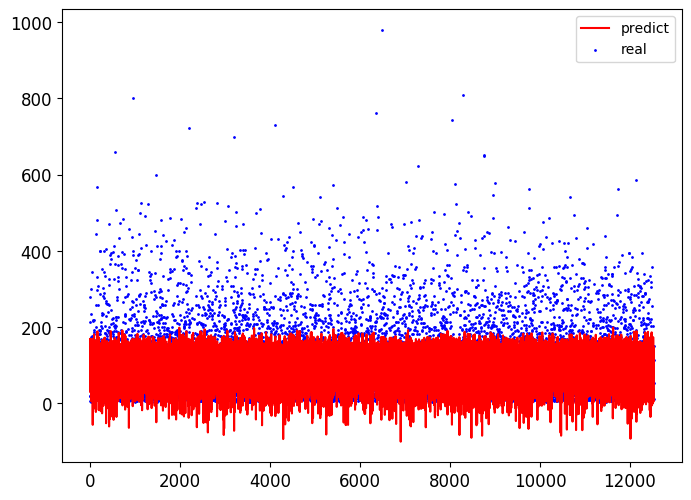

In [265]:
plt.rcParams['savefig.dpi']=300 #像素
plt.rcParams['figure.dpi'] = 100 #分辨率
plt.rcParams['figure.figsize']=(8.0,6.0)
plt.figure()
plt.scatter(list(range(len(y_pre))),y_test,label='real',color='b',s=1)
plt.plot(list(range(len(y_pre))),y_pre,label='predict',color='r')
plt.legend()
plt.show()


k-fold cross validation

In [266]:
cv = KFold(n_splits=10, shuffle=True, random_state=1)
scores = cross_val_score(linear, X_test, y_test, scoring='neg_mean_squared_error', cv=cv)
scores

array([-6610.84765487, -6263.31373388, -6815.48652666, -6894.99137959,
       -5698.09040288, -6518.5891993 , -6489.59418911, -6699.22204122,
       -5560.58802816, -6577.51346584])

In [267]:
# fix the sign of MSE scores
mse_scores = -scores
print(mse_scores)

[6610.84765487 6263.31373388 6815.48652666 6894.99137959 5698.09040288
 6518.5891993  6489.59418911 6699.22204122 5560.58802816 6577.51346584]


In [268]:
# convert from MSE to RMSE
rmse_scores = np.sqrt(mse_scores)
print(rmse_scores)
# calculate the average RMSE
print(rmse_scores.mean())

[81.30711934 79.14110016 82.55595997 83.0360848  75.48569668 80.7377805
 80.55801753 81.84877544 74.56935046 81.10187091]
80.03417557913403


In [0]:
# 定义一个评价函数
def r2_score(y_true, y_predict):
    """计算y_true和y_predict之间的MSE"""
    MSE = np.sum((y_true - y_predict) ** 2) / len(y_true)
    """计算y_true和y_predict之间的R Square"""
    return 1 - MSE / np.var(y_true)
 
 
# 线性回归，【参考某大佬的代码】
 
class LinearRegression:
 
    def __init__(self):
        """初始化Linear Regression模型"""
        self.coef_ = None
        self.intercept_ = None
        self._theta = None
 
    def fit_normal(self, X_train, y_train):
        """根据训练数据集X_train, y_train训练Linear Regression模型"""
        assert X_train.shape[0] == y_train.shape[0], \
            "the size of X_train must be equal to the size of y_train"
 
        X_b = np.hstack([np.ones((len(X_train), 1)), X_train])
        self._theta = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y_train)
 
        self.intercept_ = self._theta[0]
        self.coef_ = self._theta[1:]
 
        return self
 
    def fit_gd(self, X_train, y_train, eta=0.01, n_iters=1e4):
        '''
        :param X_train: 训练集
        :param y_train: label
        :param eta: 学习率
        :param n_iters: 迭代次数
        :return: theta
        '''
 
 
        """根据训练数据集X_train, y_train, 使用梯度下降法训练Linear Regression模型"""
        assert X_train.shape[0] == y_train.shape[0], \
            "the size of X_train must be equal to the size of y_train"
 
        '''定义一个损失函数'''
        def J(theta, X_b, y):
            try:
                return np.sum((y - X_b.dot(theta)) ** 2) / len(y)
            except:
                return float('inf')
        '''对损失函数求导'''
        def dJ(theta, X_b, y):
            return X_b.T.dot(X_b.dot(theta) - y) * 2. / len(y)
 
        def gradient_descent(X_b, y, initial_theta, eta, n_iters=1e4, epsilon=1e-8):
            '''
            :param X_b:
            :param y: lebel
            :param initial_theta: 初始theta值
            :param eta: 学习率
            :param n_iters: 迭代次数
            :param epsilon: theta更新变化值
            :return:
            '''
            theta = initial_theta
            cur_iter = 0
 
            while cur_iter < n_iters:
                gradient = dJ(theta, X_b, y)
                last_theta = theta
                theta = theta - eta * gradient
                if (abs(J(theta, X_b, y) - J(last_theta, X_b, y)) < epsilon):
                    break
 
                cur_iter += 1
 
            return theta
 
        X_b = np.hstack([np.ones((len(X_train), 1)), X_train])
 
 
        initial_theta = np.zeros(X_b.shape[1])
        self._theta = gradient_descent(X_b, y_train, initial_theta, eta, n_iters)
 
        self.intercept_ = self._theta[0]
        self.coef_ = self._theta[1:]
 
        return self
 
    def predict(self, X_predict):
        """给定待预测数据集X_predict，返回表示X_predict的结果向量"""
        assert self.intercept_ is not None and self.coef_ is not None, \
            "must fit before predict!"
        assert X_predict.shape[1] == len(self.coef_), \
            "the feature number of X_predict must be equal to X_train"
 
        X_b = np.hstack([np.ones((len(X_predict), 1)), X_predict])
        return X_b.dot(self._theta)
 
    def score(self, X_test, y_test):
        """根据测试数据集 X_test 和 y_test 确定当前模型的准确度"""
 
        y_predict = self.predict(X_test)
        return r2_score(y_test, y_predict)
 
    def __repr__(self):
        return "LR()"
        

In [270]:
import numpy as np
LR = LinearRegression().fit_gd(X_train, y_train)
 
print(LR.score(X_train, y_train))

result = LR.predict(X_test)

0.2521910510465366


In [0]:
cv = KFold(n_splits=10, shuffle=True, random_state=1)
scores = cross_val_score(LR, X_test, y_test, scoring='neg_mean_squared_error', cv=cv)
scores

In [0]:
# fix the sign of MSE scores
mse_scores = -scores
print(mse_scores)

In [0]:
# convert from MSE to RMSE
rmse_scores = np.sqrt(mse_scores)
print(rmse_scores)
# calculate the average RMSE
print(rmse_scores.mean())

In [357]:
from sklearn.linear_model import Ridge,RidgeCV

lambdas = np.logspace(-5,2,200)
ridge_cv = RidgeCV(alphas=lambdas,normalize=True,scoring="neg_mean_squared_error",cv=10)
ridge_cv.fit(X_train,y_train)
ridge_cv_model=ridge_cv.fit(X_train,y_train)
ridge_cv.alpha_



model=Ridge(alpha=ridge_cv.alpha_,normalize=True)
model.fit(X_train,y_train)
ridge_pre = model.predict(X_test)

mean_squared_error(y_test,ridge_pre)


r2_score(y_test,ridge_pre)


0.250024796466054

In [329]:
cv = KFold(n_splits=10, shuffle=True, random_state=1)
scores = cross_val_score(ridge_cv_model, X_test, y_test, scoring='neg_mean_squared_error', cv=cv)
scores

array([-6611.10750237, -6263.32926832, -6815.60522653, -6895.08429177,
       -5697.96711527, -6518.38804028, -6489.57301114, -6699.35017439,
       -5560.41130737, -6577.50940247])

In [330]:
# fix the sign of MSE scores
mse_scores = -scores
print(mse_scores)

[6611.10750237 6263.32926832 6815.60522653 6895.08429177 5697.96711527
 6518.38804028 6489.57301114 6699.35017439 5560.41130737 6577.50940247]


In [331]:
# convert from MSE to RMSE
rmse_scores = np.sqrt(mse_scores)
print(rmse_scores)
# calculate the average RMSE
print(rmse_scores.mean())

[81.30871726 79.1411983  82.55667887 83.03664427 75.48488004 80.73653473
 80.55788609 81.84955818 74.56816551 81.10184586]
80.03421091197548


# **non-linear regression**

In [275]:

poly_features = PolynomialFeatures(degree=2,include_bias=False)
X_poly = poly_features.fit_transform(X_train)
X_train[0]

array([-1.08772482, -1.50844197,  1.12083643, -0.71025627, -0.46336544,
       -0.07191939, -0.13587022])

In [276]:
X_poly[0]

array([-1.08772482, -1.50844197,  1.12083643, -0.71025627, -0.46336544,
       -0.07191939, -0.13587022,  1.18314529,  1.64076978, -1.21916161,
        0.77256338,  0.5040141 ,  0.07822851,  0.14778942,  2.27539718,
       -1.69071672,  1.07138037,  0.69895988,  0.10848623,  0.20495235,
        1.25627431, -0.7960811 , -0.51935687, -0.08060987, -0.1522883 ,
        0.50446397,  0.32910821,  0.0510812 ,  0.09650268,  0.21470754,
        0.03332496,  0.06295757,  0.0051724 ,  0.0097717 ,  0.01846072])

In [282]:
lin_reg=LinearRegression()

lin_reg=lin_reg.fit(X_poly, y_train)
lin_reg.intercept_, lin_reg.coef_


(100.19308632712918,
 array([ 73.76550302, -81.94502186,  -9.85806926,  15.97075507,
        -13.97928215,  -5.47441648, -17.62734771,  20.97278139,
        -58.50227002,   1.3133354 ,   0.30461361, -10.70153942,
          8.72950757,  -0.66631137,  35.58544185,   2.74986015,
          1.6456127 ,  15.68074481,  -0.27444167,   5.22018469,
         -6.95689082,   0.56001146,   6.1840197 ,   1.11658842,
          0.34155416,  -1.78565379,  16.9045753 ,  -1.18919698,
         -0.48311607,   2.56451328,   0.82324316,   2.11036037,
          0.25802129,   2.01155832,   0.62163501]))

In [283]:

X_new_poly = poly_features.fit_transform(X_test)
X_new_poly[0]


array([-0.61601685, -1.60049051,  0.34903118, -0.70106467, -0.15639275,
       -0.06900519, -0.14099373,  0.37947676,  0.98592912, -0.21500909,
        0.43186765,  0.09634057,  0.04250836,  0.08685452,  2.56156986,
       -0.55862109,  1.12204734,  0.25030512,  0.11044215,  0.22565913,
        0.12182276, -0.24469343, -0.05458595, -0.02408496, -0.04921121,
        0.49149167,  0.10964143,  0.0483771 ,  0.09884573,  0.02445869,
        0.01079191,  0.0220504 ,  0.00476172,  0.0097293 ,  0.01987923])

In [284]:
X_test[0]

array([-0.61601685, -1.60049051,  0.34903118, -0.70106467, -0.15639275,
       -0.06900519, -0.14099373])

In [0]:
y_hat=lin_reg.predict(X_poly)
y_pre=lin_reg.predict(X_new_poly )
fmse=(y_pre-y_test).T.dot(y_pre-y_test)/len(y_test)
mse=(y_hat-y_train).T.dot(y_hat-y_train)/len(y_train)

In [286]:
fmse

5944.725513152999

In [287]:
mse

5809.422279976005

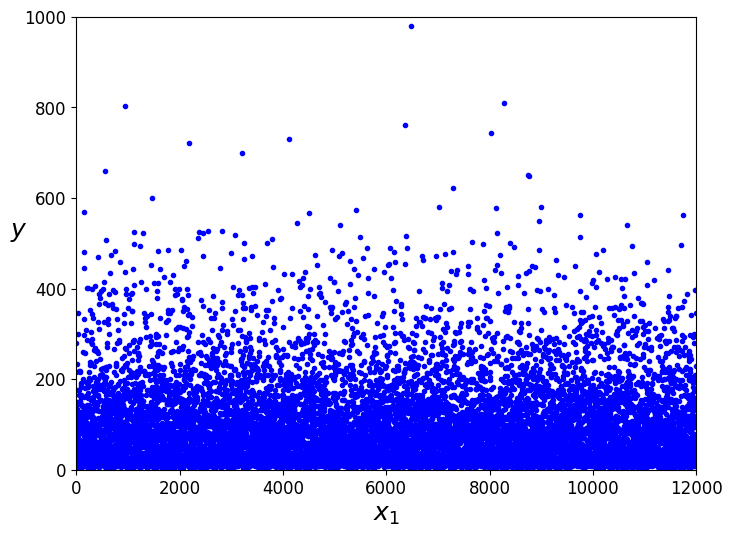

In [288]:
plt.plot(list(range(len(y_test))), y_test, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 12000, 0, 1000])

plt.show()

In [289]:

lin_reg.fit(X_new_poly , y_test)
lin_reg.intercept_, lin_reg.coef_

(100.52996001133839,
 array([ 69.7490905 , -81.48910535, -12.50757097,  17.94120959,
        -13.95353778,   0.17148735, -14.83934944,  17.96318033,
        -54.27573804,  -2.47986438,   2.007339  , -11.61188841,
          7.8816051 ,  -4.97127418,  37.10450729,  11.75900096,
          0.84642126,  17.84053741,   1.76890619,   6.97418929,
         -3.14953152,   3.40648874,   7.61505773,  -1.87934885,
          0.48098899,  -2.41547057,  18.68147937,  -1.22304536,
         -0.35071059,   2.56641828,  -0.202123  ,   1.81851741,
          0.25787873,   0.99981348,   0.6646511 ]))

No handles with labels found to put in legend.


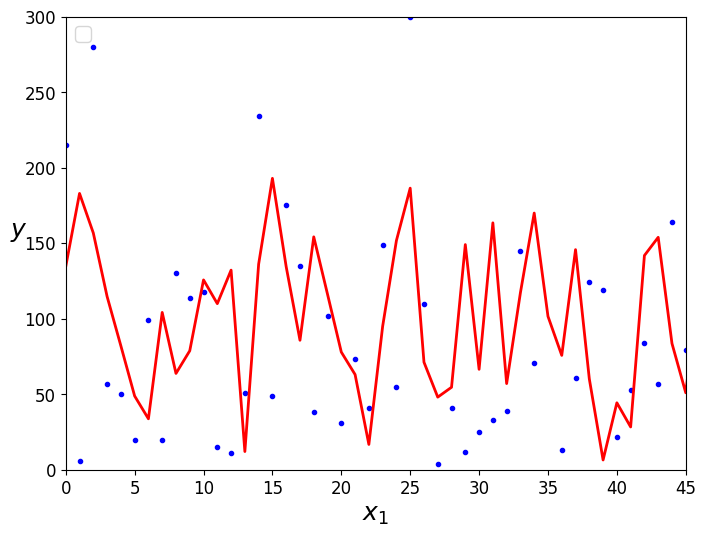

In [290]:
y_pre=lin_reg.predict(X_poly)
plt.plot(list(range(len(y_test))), y_test, "b.")
plt.plot( list(range(len(y_pre))),y_pre, "r-", linewidth=2)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 45, 0, 300])

plt.show()

In [232]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = linear_model.LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new_poly)
    plt.plot(list(range(len(y_newbig))), y_newbig, style, label=str(degree), linewidth=width)

plt.plot(list(range(len(y_test))), y_test, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 12000, 0, 1000])

plt.show()

KeyboardInterrupt: ignored

k-fold cross validation

In [291]:
cv = KFold(n_splits=10, shuffle=True, random_state=1)
scores = cross_val_score(lin_reg, X_new_poly, y_test, scoring='neg_mean_squared_error', cv=cv)
scores

array([-6125.83247532, -5783.74339408, -6277.88259285, -6300.84876303,
       -5325.41106387, -6126.22304944, -6095.68008903, -6162.59655695,
       -5195.71121753, -6114.05150467])

In [292]:
# fix the sign of MSE scores
mse_scores = -scores
print(mse_scores)

[6125.83247532 5783.74339408 6277.88259285 6300.84876303 5325.41106387
 6126.22304944 6095.68008903 6162.59655695 5195.71121753 6114.05150467]


In [293]:
# convert from MSE to RMSE
rmse_scores = np.sqrt(mse_scores)
print(rmse_scores)
# calculate the average RMSE
print(rmse_scores.mean())

[78.26769752 76.05092632 79.23309026 79.37788586 72.97541411 78.2701926
 78.07483646 78.50220734 72.08128202 78.19240056]
77.10259330442963


# **learning curves for all models** 

for linear

In [0]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set size", fontsize=14) # not shown
    plt.ylabel("RMSE", fontsize=14) 

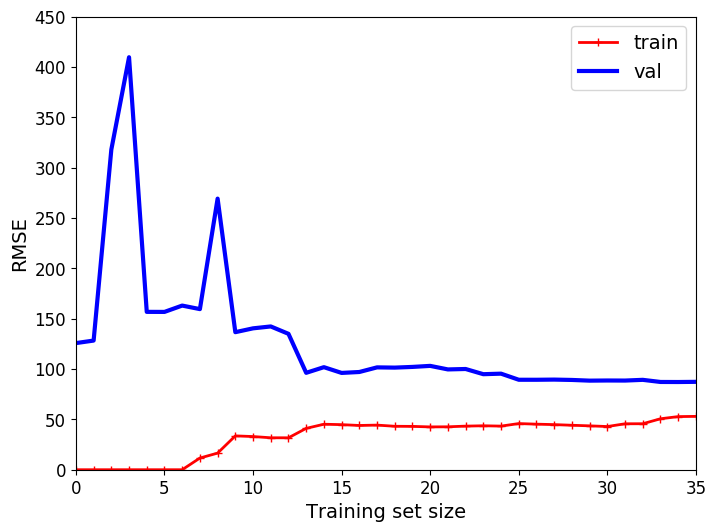

In [237]:

plot_learning_curves(linear, X, y)
plt.axis([0, 35, 0, 450])                         # not shown in the book
plt.show()

for non linear

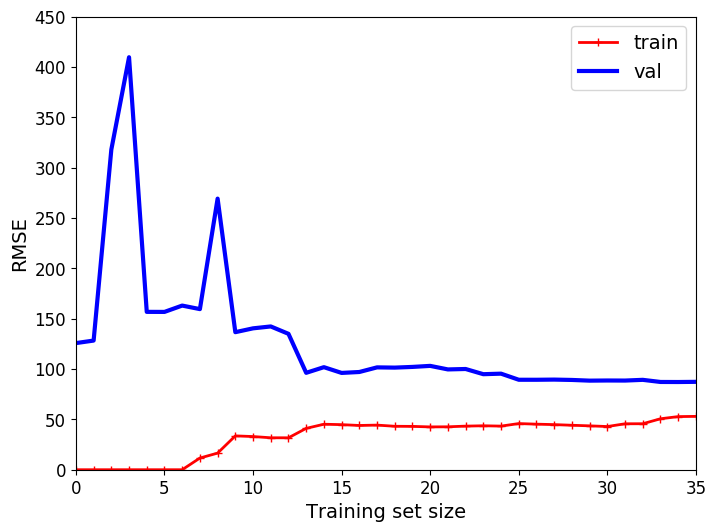

In [295]:
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 35, 0, 450])                         # not shown in the book
plt.show()

In [359]:
plot_learning_curves(ridge_cv_model, X, y)
plt.axis([0, 35, 0, 450])                         # not shown in the book
plt.show()

ValueError: ignored